In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

**This model will only take into account pictures to see if they are anyhow valuable.**

In [4]:
# Loading numeric data for final predictions

chances=pd.read_excel('Chances.xlsm')

chances.head()

Header  Controlled Ball  Pressured  Area  Side  Good chance  Penalty  Goal
0       0                1          0     0     0            0        0     0
1       0                1          1     1     1            0        0     0
2       1                0          0     1     0            0        0     0
3       0                1          1     0     1            0        0     0
4       1                0          0     1     1            0        0     0

In [3]:
# Loading images for further results inspection

images = []
labels = []

for i in range(1, 107):
    img_path = f"Gole/{i}.png"
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    images.append(img)
    labels.append(chances.at[i-1, 'Goal'])

images = np.array(images)
labels = np.array(labels)

In [4]:
chances=chances.iloc[:,:-1]

In [5]:
chances

Header  Controlled Ball  Pressured  Area  Side  Good chance  Penalty
0         0                1          0     0     0            0        0
1         0                1          1     1     1            0        0
2         1                0          0     1     0            0        0
3         0                1          1     0     1            0        0
4         1                0          0     1     1            0        0
..      ...              ...        ...   ...   ...          ...      ...
101       0                1          1     1     1            0        0
102       0                0          0     1     0            1        0
103       0                1          0     0     0            0        0
104       0                0          0     1     0            1        0
105       0                1          1     0     0            0        0

[106 rows x 7 columns]

In [6]:
tf.random.set_seed(42)

In [7]:
# Defining the model architecture

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 4)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
# Learning parameters and compiling

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
# Data splitting

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [11]:
model.fit(X_train, y_train, epochs=15, batch_size=30, validation_data=(X_val, y_val))

Epoch 1/15


3/3 [==============================] - 6s 1s/step - loss: 3.0113 - accuracy: 0.5132 - val_loss: 2.6458 - val_accuracy: 0.4286
Epoch 2/15
3/3 [==============================] - 2s 784ms/step - loss: 1.4837 - accuracy: 0.4868 - val_loss: 0.7360 - val_accuracy: 0.5714
Epoch 3/15
3/3 [==============================] - 2s 724ms/step - loss: 0.6814 - accuracy: 0.6184 - val_loss: 0.6818 - val_accuracy: 0.5714
Epoch 4/15
3/3 [==============================] - 2s 741ms/step - loss: 0.6671 - accuracy: 0.6184 - val_loss: 0.6823 - val_accuracy: 0.5714
Epoch 5/15
3/3 [==============================] - 2s 704ms/step - loss: 0.6778 - accuracy: 0.6184 - val_loss: 0.6825 - val_accuracy: 0.5714
Epoch 6/15
3/3 [==============================] - 2s 754ms/step - loss: 0.6526 - accuracy: 0.6184 - val_loss: 0.6819 - val_accuracy: 0.5714
Epoch 7/15
3/3 [==============================] - 2s 714ms/step - loss: 0.6681 - accuracy: 0.6711 - val_loss: 0.6806 - val_accuracy: 0.5714
Epoch 8/15
3/3 [=====

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 263ms/step - loss: 0.6296 - accuracy: 0.6875


In [13]:
y_pred_prob = model.predict(X_test)

1/1 [==============================] - 1s 500ms/step


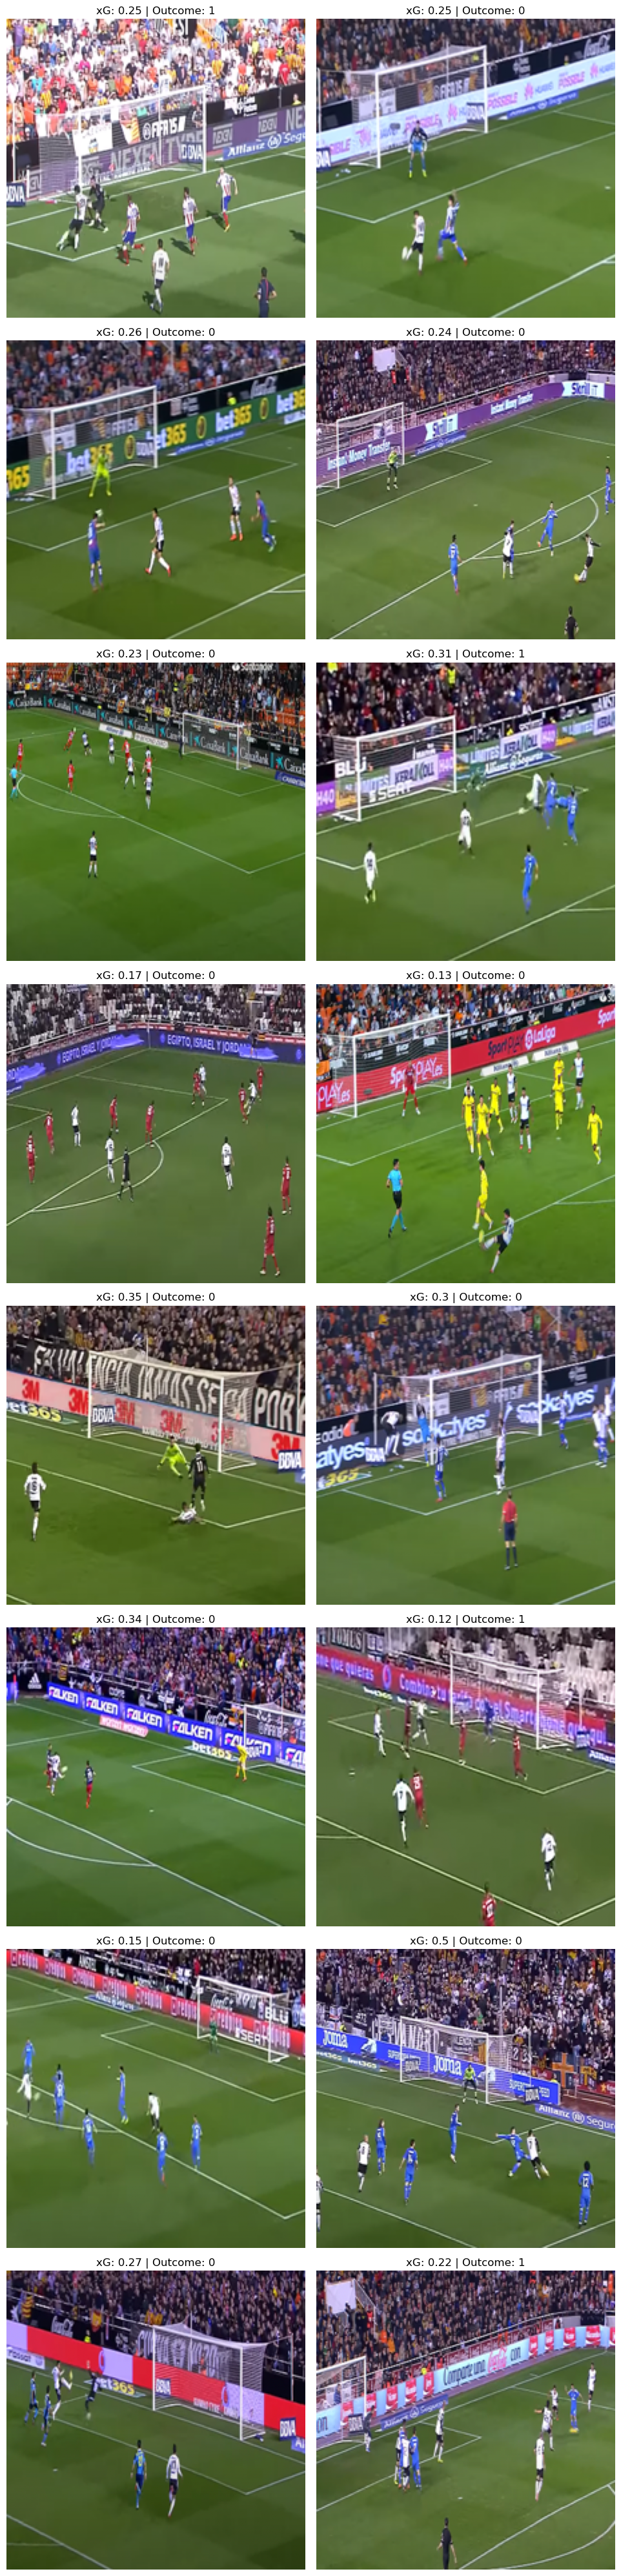

In [14]:
# Showing results for each test pic

num_images = y_test.shape[0]
num_rows = (num_images + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

if num_rows == 1:
    axs = axs.reshape(1, -1)

for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(X_test[i])
    axs[row, col].axis('off')
    axs[row, col].set_title(f"xG: {round(float(y_pred_prob[i][0]), 2)} | Outcome: {y_test[i]}")

for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Final remarks

**Model achieves solid results, in some cases the results are more reasonable than for the binary one. However, the overall performance is slightly worse.**